# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Данные включают в себя следующие параметры:

- id — уникальный идентификатор скважины
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы)
- product — объём запасов в скважине (тыс. баррелей)

Прямая ссылка на [Первый регион](https://code.s3.yandex.net/datasets/geo_data_0.csv).
Прямая ссылка на [Второй регион](https://code.s3.yandex.net/datasets/geo_data_1.csv).
Прямая ссылка на [Третий регион](https://code.s3.yandex.net/datasets/geo_data_2.csv).

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV


In [2]:
geo_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
geo_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
geo_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

### Проверка данных первого региона

Определяю функцию для анализа датафреймов.

In [3]:
def data_info(data):
    print('Информация о типах данных')
    print('')
    data.info()
    print('=' * 75)
    
    print('Размер дата фрейма')
    display(data.shape)
    print('=' * 75)
    
    print('Основная статестическая информация')
    display(data.describe().style.format('{0:.2f}'))
    print('=' * 75)
    
    print('Пропущенные значения')
    display(data.isna().sum())
    print('=' * 75)
    
    print('Гистограммы и диаграммы рассеяния фичей')
    sns.pairplot(geo_1, diag_kind='hist', plot_kws={'s': 10});
    plt.show()
    print('=' * 75)
    
    print('Боксплоты фичей')
    columns = data.loc[:, data.dtypes.isin(['int64', 'float64'])].columns
    for col in columns:
        plt.figure(figsize=(4, 6))
        sns.boxplot(data=data[col], orient='v')
        plt.title(col)
        plt.grid(True)
        plt.show()
    print('=' * 75)
    
    print('Тепловая карта корреляций признаков')
    plt.figure(figsize=(8, 6))
    sns.heatmap(data.corr(), annot=True, fmt='.2f');
    plt.show()
    print('=' * 75)
    
    print('Таблица значений корреляций')
    data.corr()
    print('=' * 75)
    
    print('Подсчёт пропущенных значений')
    print(f'Количество пропущенных значений: {data.isna().sum()}')
    print('=' * 75)
    
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    print('=' * 75)
    

Определяю функцию для проверки на дубликаты по 2м различным столбцам.

In [4]:
def duplicates_checker(data):
    columns = data.columns
    for col1, col2 in itertools.combinations(columns, 2):
        print(col1, '<==>', col2)
        print(data.duplicated(subset=[col1, col2]).sum())

Вызовем функцию на каждый дф

Информация о типах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Размер дата фрейма


(100000, 5)

Основная статестическая информация


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


Пропущенные значения


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Гистограммы и диаграммы рассеяния фичей


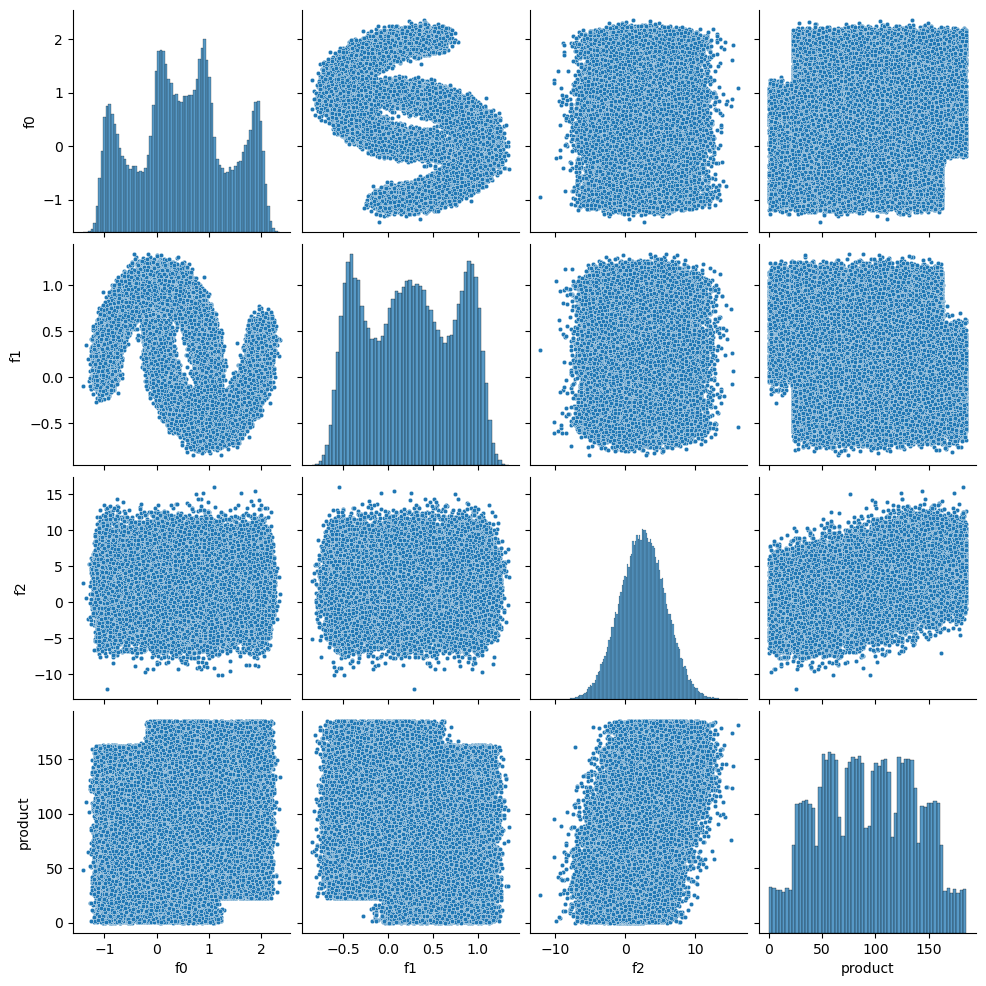

Боксплоты фичей
Тепловая карта корреляций признаков


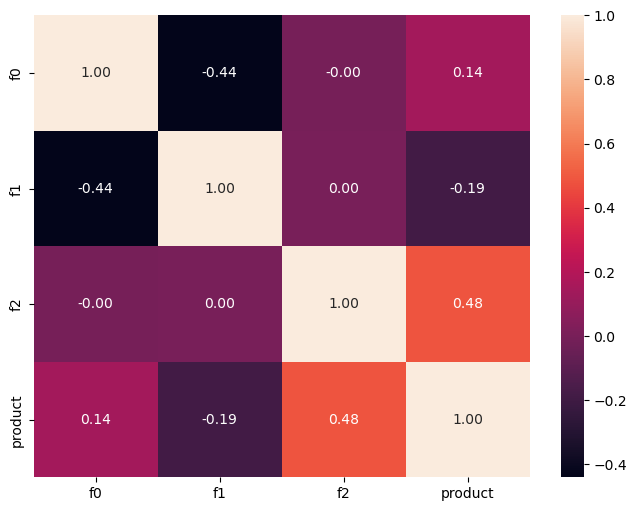

Таблица значений корреляций
Подсчёт пропущенных значений
Количество пропущенных значений: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество явных дубликатов: 0


In [5]:
data_info(geo_1)

Аномальных значений не обнаруено, мультиколлениарность признаков мала. Есть нелинейная сложная взаимосвязть признаков f0 и f1.

Проверим количество явных дубликатов по основным обучающим признакам.

In [6]:
geo_1.duplicated(subset=['f0', 'f1', 'f2']).sum()

0

Проверим попарные дубликаты функцией.

In [7]:
duplicates_checker(geo_1)

id <==> f0
0
id <==> f1
0
id <==> f2
0
id <==> product
0
f0 <==> f1
0
f0 <==> f2
0
f0 <==> product
0
f1 <==> f2
0
f1 <==> product
0
f2 <==> product
0


In [8]:
geo_1.id.duplicated().sum()

10

In [9]:
geo_1[geo_1.id.isin(geo_1[geo_1.id.duplicated()].id)].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


Найдено 10 дублирующихся значений в признаке id, их можно удалить, чтобы убрать неопределённость.

In [10]:
geo_1 = geo_1.drop_duplicates(subset='id')

In [11]:
geo_1 = geo_1.drop('id', axis=1)

### Проверка данных второго региона

Информация о типах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Размер дата фрейма


(100000, 5)

Основная статестическая информация


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


Пропущенные значения


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Гистограммы и диаграммы рассеяния фичей


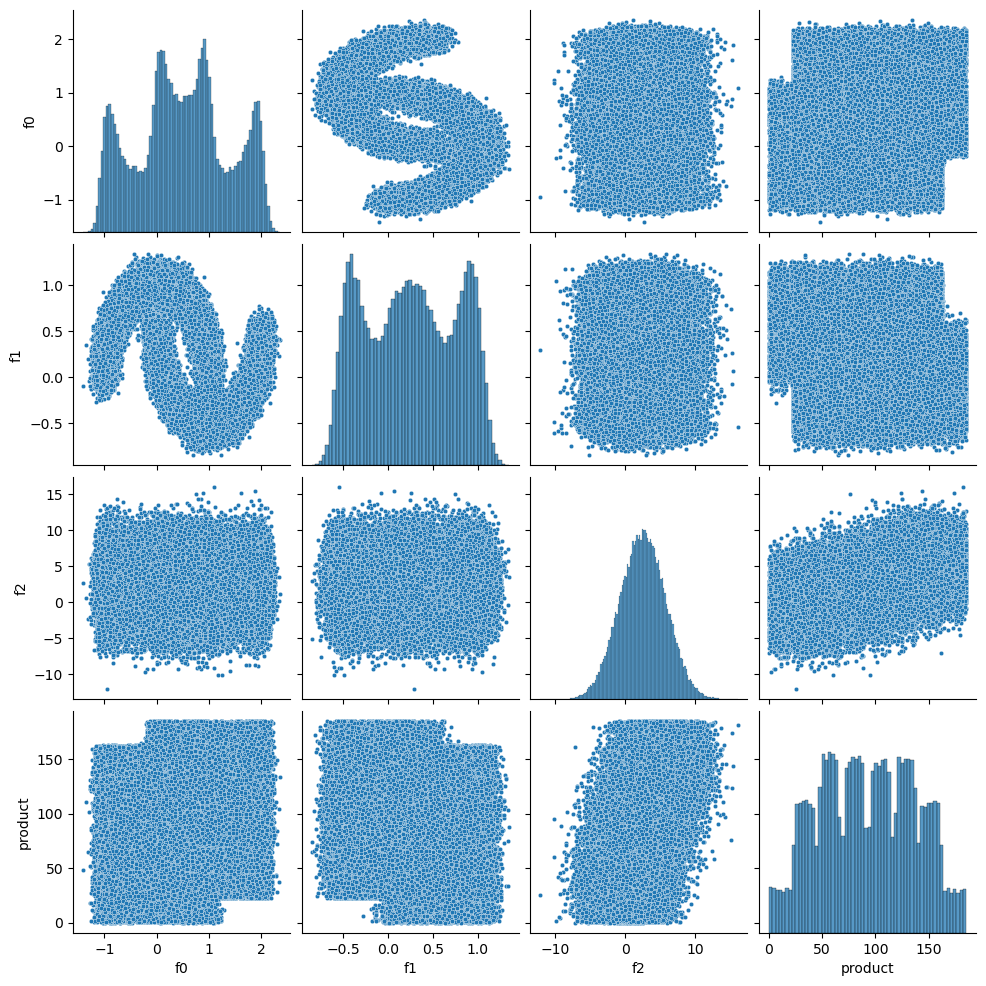

Боксплоты фичей
Тепловая карта корреляций признаков


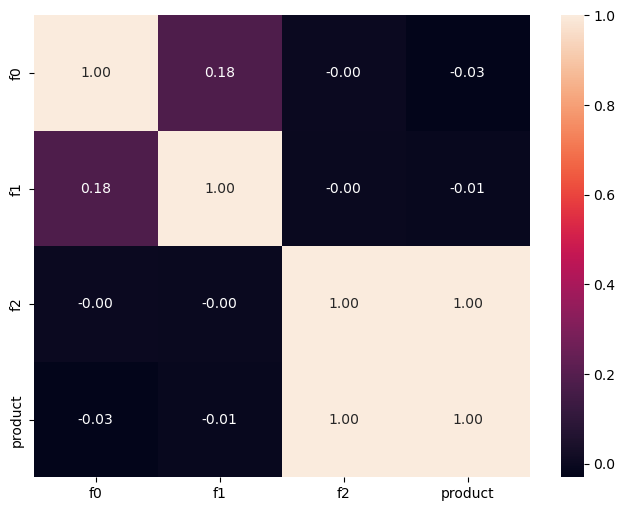

Таблица значений корреляций
Подсчёт пропущенных значений
Количество пропущенных значений: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество явных дубликатов: 0


In [12]:
data_info(geo_2)

In [13]:
len(geo_2['product'].unique())

12

Данные prduct во втором регионе имеют всего 12 уникальных значений с подозрительной корреляцией Пирсона с f2 фичей. Скорее всего эти данные повреждены и это стоит отметить.

Проверим количество явных дубликатов по основным обучающим признакам.

In [14]:
geo_2.duplicated(subset=['f0', 'f1', 'f2']).sum()

0

In [15]:
duplicates_checker(geo_2)

id <==> f0
0
id <==> f1
0
id <==> f2
0
id <==> product
0
f0 <==> f1
0
f0 <==> f2
0
f0 <==> product
0
f1 <==> f2
0
f1 <==> product
0
f2 <==> product
0


In [16]:
geo_2.id.duplicated().sum()

4

In [17]:
geo_2[geo_2.id.isin(geo_2[geo_2.id.duplicated()].id)].sort_values(by='id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


Найдено 4 дублирующихся значений в признаке id, их можно удалить, чтобы убрать неопределённость.

In [18]:
geo_2 = geo_2.drop_duplicates(subset='id')

In [19]:
geo_2.index = geo_2.id
geo_2 = geo_2.drop('id', axis=1)

### Проверка данных третьего региона

Информация о типах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Размер дата фрейма


(100000, 5)

Основная статестическая информация


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


Пропущенные значения


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Гистограммы и диаграммы рассеяния фичей


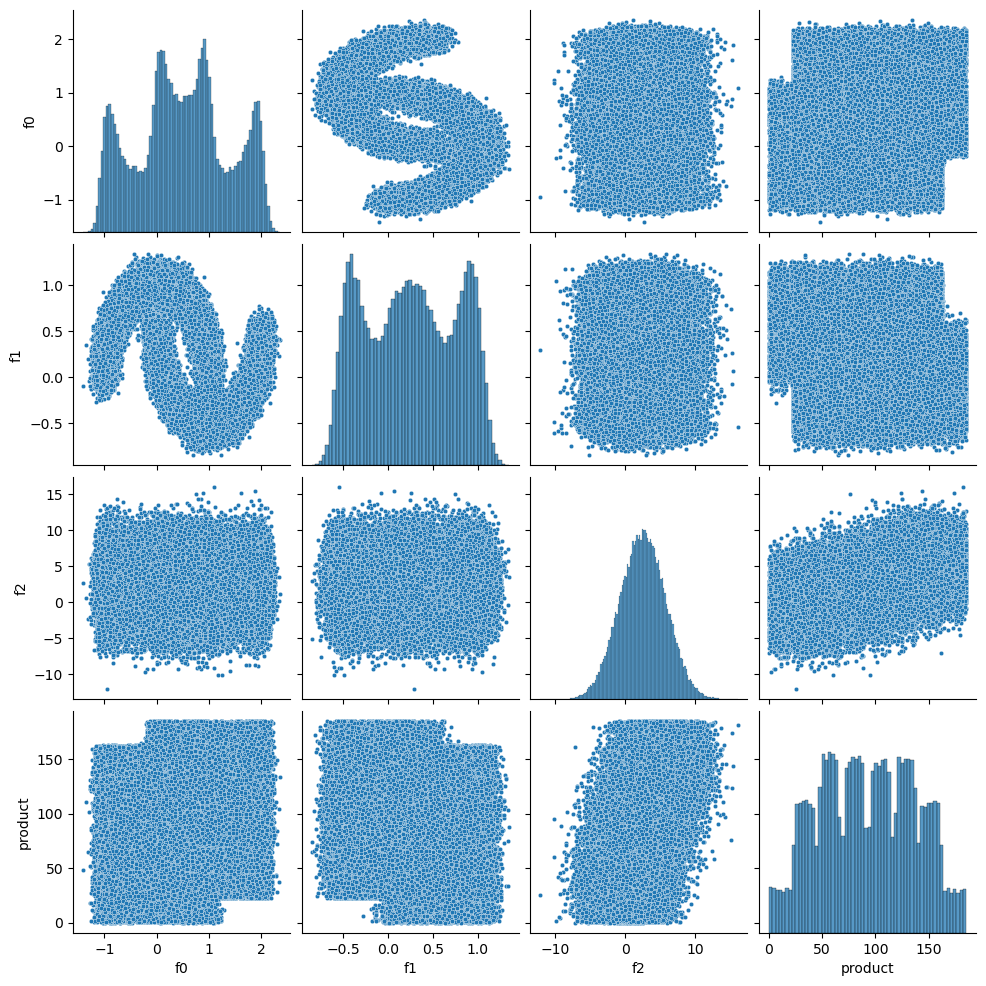

Боксплоты фичей
Тепловая карта корреляций признаков


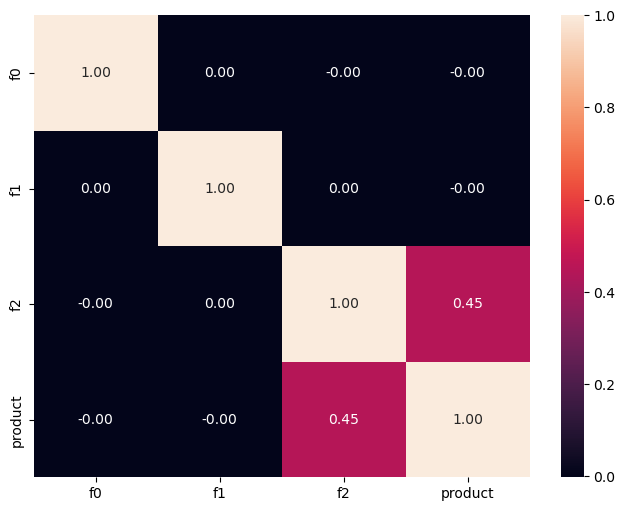

Таблица значений корреляций
Подсчёт пропущенных значений
Количество пропущенных значений: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество явных дубликатов: 0


In [20]:
data_info(geo_3)

Проверим количество явных дубликатов по основным обучающим признакам.

In [21]:
geo_3.duplicated(subset=['f0', 'f1', 'f2']).sum()

0

In [22]:
duplicates_checker(geo_3)

id <==> f0
0
id <==> f1
0
id <==> f2
0
id <==> product
0
f0 <==> f1
0
f0 <==> f2
0
f0 <==> product
0
f1 <==> f2
0
f1 <==> product
0
f2 <==> product
0


In [23]:
geo_3.id.duplicated().sum()

4

In [24]:
geo_3[geo_3.id.isin(geo_3[geo_3.id.duplicated()].id)].sort_values(by='id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Так же обнаружено 4 дублирующихся значения в колонке id.

In [25]:
geo_3 = geo_3.drop_duplicates(subset='id')

In [26]:
geo_3.index = geo_3.id
geo_3 = geo_3.drop('id', axis=1)

## Обучение и проверка модели

Создадим обучающую и валидационную выборки и проверим их точность на голой линейной регрессии.

In [27]:
features_geo1 = geo_1.drop('product', axis=1)
target_geo1 = geo_1['product']

In [28]:
R_SEED = 32

features_geo1_train, features_geo1_valid, target_geo1_train, target_geo1_valid = train_test_split(features_geo1,
                                                                                                  target_geo1,
                                                                                                  test_size=0.25,
                                                                                                  random_state=R_SEED)

In [29]:
lr_geo_1 = LinearRegression()
lr_geo_1.fit(features_geo1_train, target_geo1_train)
cvs = -cross_val_score(lr_geo_1, features_geo1_train, target_geo1_train, cv=5, scoring='neg_root_mean_squared_error')
RMSE_original = np.mean(cvs)
RMSE_original

37.620956758699585

### Модель первого региона

Посмотрим, как изменится точность модели, если мы добавим скалирование признаков.

In [30]:
test_geo1 = geo_1.copy()
features_geo1 = test_geo1.drop('product', axis=1)
target_geo1 = test_geo1['product']
features_geo1_train, features_geo1_valid, target_geo1_train, target_geo1_valid = train_test_split(features_geo1,
                                                                                                  target_geo1,
                                                                                                  test_size=0.25,
                                                                                                  random_state=R_SEED)
scaler = StandardScaler()
scaler.fit(features_geo1_train)
features_geo1_train = scaler.transform(features_geo1_train)
features_geo1_valid = scaler.transform(features_geo1_valid)
    
lr_geo_1 = LinearRegression()
lr_geo_1.fit(features_geo1_train, target_geo1_train)
    
cvs = -cross_val_score(lr_geo_1, features_geo1_train, target_geo1_train, cv=5, scoring='neg_root_mean_squared_error')
print(np.mean(cvs))
if np.mean(cvs) > RMSE_original:
    print('Скалирование улучшило оценку')
elif np.mean(cvs) < RMSE_original:
    print('Скалирование ухудшило оценку')
else:
    print('Скалирование не повлияло на оценку')
    


37.620956758699585
Скалирование не повлияло на оценку


Посмотрим, насколько PolynomialFeatures могут улучшить оценку.

In [31]:
cvs_mean_list = []
for degree in range(1, 6):
    test_geo1 = geo_1.copy()
    features_geo1 = test_geo1.drop('product', axis=1)
    target_geo1 = test_geo1['product']
    features_geo1_train, features_geo1_valid, target_geo1_train, target_geo1_valid = train_test_split(features_geo1,
                                                                                                  target_geo1,
                                                                                                  test_size=0.25,
                                                                                                  random_state=R_SEED)
    
    scaler = StandardScaler()
    scaler.fit(features_geo1_train)
    features_geo1_train = scaler.transform(features_geo1_train)
    features_geo1_valid = scaler.transform(features_geo1_valid)
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly.fit(features_geo1_train)
    features_geo1_train_poly = poly.transform(features_geo1_train)
    features_geo1_valid_poly = poly.transform(features_geo1_valid)
    
    lr_geo_1 = LinearRegression()
    lr_geo_1.fit(features_geo1_train_poly, target_geo1_train)
    
    cvs = -cross_val_score(lr_geo_1, features_geo1_train_poly, target_geo1_train, cv=5, scoring='neg_root_mean_squared_error')
    cvs_mean_list.append(np.mean(cvs))
    


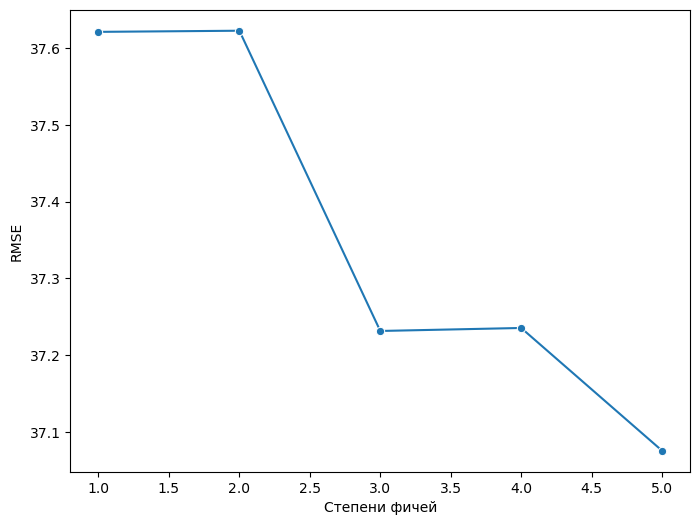

In [32]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=list(range(1, 6)), y=cvs_mean_list, marker='o')
plt.xlabel('Степени фичей')
plt.ylabel('RMSE')
plt.show();

In [33]:
cvs_mean_list = []
for degree in range(5, 8):
    test_geo1 = geo_1.copy()
    features_geo1 = test_geo1.drop('product', axis=1)
    target_geo1 = test_geo1['product']
    features_geo1_train, features_geo1_valid, target_geo1_train, target_geo1_valid = train_test_split(features_geo1,
                                                                                                  target_geo1,
                                                                                                  test_size=0.25,
                                                                                                  random_state=32)
    
    scaler = StandardScaler()
    scaler.fit(features_geo1_train)
    features_geo1_train = scaler.transform(features_geo1_train)
    features_geo1_valid = scaler.transform(features_geo1_valid)
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly.fit(features_geo1_train)
    features_geo1_train_poly = poly.transform(features_geo1_train)
    features_geo1_valid_poly = poly.transform(features_geo1_valid)
    
    lr_geo_1 = LinearRegression()
    lr_geo_1.fit(features_geo1_train_poly, target_geo1_train)
    
    cvs = -cross_val_score(lr_geo_1, features_geo1_train_poly, target_geo1_train, cv=5, scoring='neg_root_mean_squared_error')
    cvs_mean_list.append(np.mean(cvs))
    


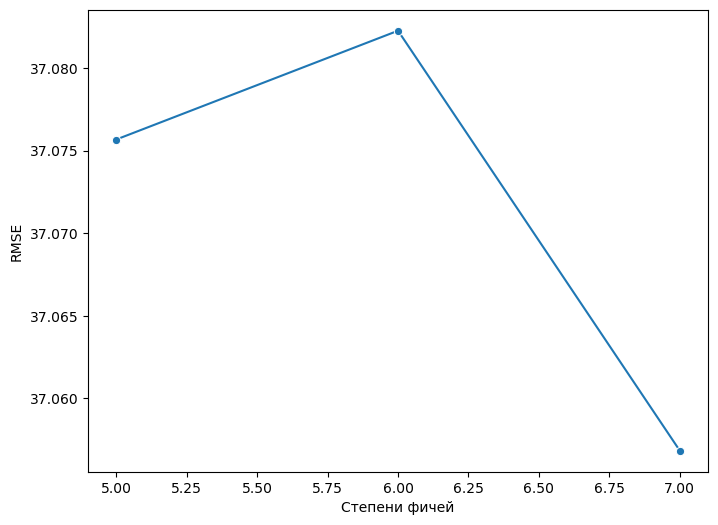

In [34]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=list(range(5, 8)), y=cvs_mean_list, marker='o')
plt.xlabel('Степени фичей')
plt.ylabel('RMSE')
plt.show();

Оценка после показатиля степеней в 5 очень слабо меняется, но такое значение может сильно повлиять на переобучение и ухудшит инторпритацию, если она понадобится. Оставим значение степеней равным 3.

Посмотрим, улучшил ли качество модели, если из неё убрать некоторые признаки.

In [35]:
cvs_mean_list = []
for component in range(13, 20):
    test_geo1 = geo_1.copy()
    features_geo1 = test_geo1.drop('product', axis=1)
    target_geo1 = test_geo1['product']
    features_geo1_train, features_geo1_valid, target_geo1_train, target_geo1_valid = train_test_split(features_geo1,
                                                                                                  target_geo1,
                                                                                                  test_size=0.25,
                                                                                                  random_state=32)
    
    scaler = StandardScaler()
    scaler.fit(features_geo1_train)
    features_geo1_train = scaler.transform(features_geo1_train)
    features_geo1_valid = scaler.transform(features_geo1_valid)
 
    
    poly = PolynomialFeatures(degree=3, include_bias=False)
    poly.fit(features_geo1_train)
    features_geo1_train_poly = poly.transform(features_geo1_train)
    features_geo1_valid_poly = poly.transform(features_geo1_valid)
    
    pca = PCA(n_components=component)
    pca.fit(features_geo1_train_poly)
    features_geo1_train_poly_pca = pca.transform(features_geo1_train_poly)
    features_geo1_valid_poly_pca =pca.transform(features_geo1_valid_poly)
    
    lr_geo_1 = LinearRegression()
    lr_geo_1.fit(features_geo1_train_poly_pca, target_geo1_train)
    
    cvs = -cross_val_score(lr_geo_1, features_geo1_train_poly_pca, target_geo1_train, cv=5,
                           scoring='neg_root_mean_squared_error')
    cvs_mean_list.append(np.mean(cvs))
    


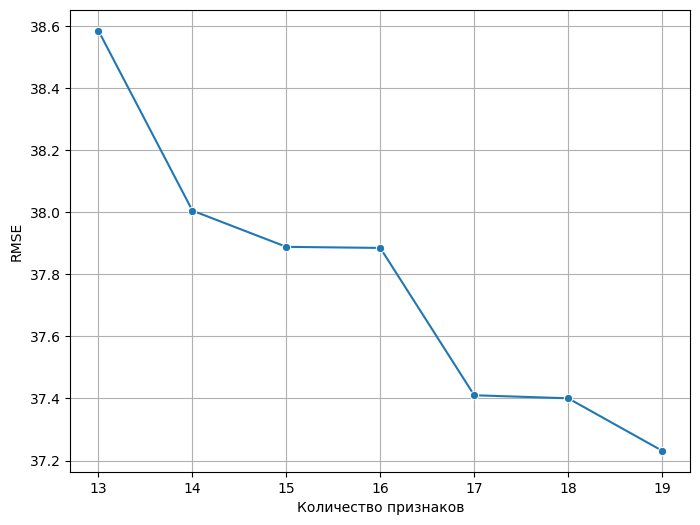

In [36]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=list(range(13, 20)), y=cvs_mean_list, marker='o')
plt.xlabel('Количество признаков')
plt.ylabel('RMSE')
plt.grid(True)
plt.show();

Если убирать добавленные признаки, модель показывает себя только хуже, не будем трогать PCA.

In [37]:
pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=3)),
                    ('lr', LinearRegression())
                    ])
pipeline.fit(features_geo1_train, target_geo1_train)
#сохраняем предсказания модели, это понадобится при расчете прибыли и рисков
geo_1_predictions = pipeline.predict(features_geo1_valid)
RMSE_geo1_valid = mean_squared_error(target_geo1_valid, geo_1_predictions, squared=False) #** 0.5
RMSE_geo1_valid

37.429421651474954

Модель для первого региона показала значение RMSE на валидационной выборке в 37.43 единицы.

Были сохранены предсказания модели, для дальнейших расчетов.

### Модель второго региона

Проверим RMSE сырого линейного регрессора для второго региона

In [38]:
features_geo2 = geo_2.drop('product', axis=1)
target_geo2 = geo_2['product']

features_geo2_train, features_geo2_valid, target_geo2_train, target_geo2_valid = train_test_split(features_geo2, target_geo2,
                                                                                                  test_size=0.25, 
                                                                                                  random_state=R_SEED)

In [39]:
geo_2_lr = LinearRegression()
geo_2_lr.fit(features_geo2_train, target_geo2_train)
np.mean(-cross_val_score(geo_2_lr, features_geo2_train, target_geo2_train, scoring='neg_root_mean_squared_error'))

0.8899961452139497

Посмотрим, насколько изменится качество модели, при добавлении PolynomialFeatures.

In [40]:
cvs_list = []
for i in list(range(1, 6)):
    pipeline = Pipeline([
                        ('scaler', StandardScaler()),
                        ('poly', PolynomialFeatures(degree=i)),
                        ('lr', LinearRegression())
                        ])
    pipeline.fit(features_geo2_train, target_geo2_train)
    cvs_list.append(np.mean(-cross_val_score(pipeline, 
                                             features_geo2_train, 
                                             target_geo2_train, 
                                             scoring='neg_root_mean_squared_error')))

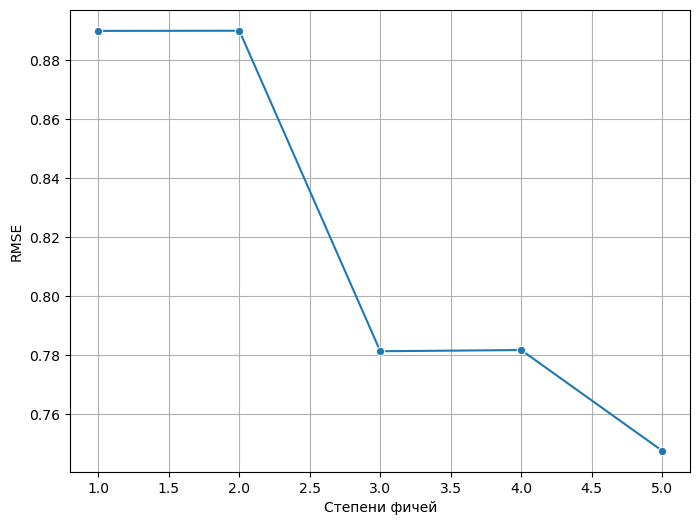

In [41]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=list(range(1, 6)), y=cvs_list, marker='o')
plt.xlabel('Степени фичей')
plt.ylabel('RMSE')
plt.grid(True)
plt.show();

На это модели, так же лучшим значением степени явялется 3, т.к далее идёт довольно слабое улучшение качества модели, но усложняется её интерпритация и увеличивается потребность в мощьностях.

In [42]:
pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=3)),
                    ('lr', LinearRegression())
                    ])
pipeline.fit(features_geo2_train, target_geo2_train)
geo_2_predictions = pipeline.predict(features_geo2_valid) #Сохраним предсказанные значения для дальшейних вычислений
RMSE_geo2_valid = mean_squared_error(target_geo2_valid, geo_2_predictions, squared=False)# ** 0.5
RMSE_geo2_valid

0.7847283228524669

Модель для второго региона показала значение RMSE на валидационной выборке в 0.78 единицы.

Были сохранены предсказания модели, для дальнейших расчетов.

### Модель третьего региона

Проверим RMSE сырого линейного регрессора для третьего региона.

In [43]:
features_geo3 = geo_3.drop('product', axis=1)
target_geo3 = geo_3['product']

features_geo3_train, features_geo3_valid, target_geo3_train, target_geo3_valid = train_test_split(features_geo3, target_geo3,
                                                                                                  test_size=0.25, 
                                                                                                  random_state=R_SEED)

In [44]:
geo_3_lr = LinearRegression()
geo_3_lr.fit(features_geo3_train, target_geo3_train)
np.mean(-cross_val_score(geo_3_lr, features_geo3_train, target_geo3_train, scoring='neg_root_mean_squared_error'))

40.1048698233597

In [45]:
cvs_list = []
for i in list(range(1, 6)):
    pipeline = Pipeline([
                        ('scaler', StandardScaler()),
                        ('poly', PolynomialFeatures(degree=i)),
                        ('lr', LinearRegression())
                        ])
    pipeline.fit(features_geo3_train, target_geo3_train)
    cvs_list.append(np.mean(-cross_val_score(pipeline, 
                                             features_geo3_train, 
                                             target_geo3_train, 
                                             scoring='neg_root_mean_squared_error')))

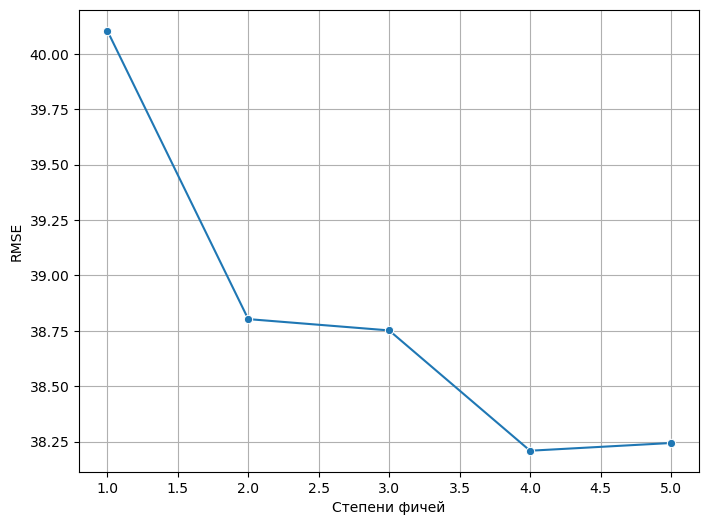

In [46]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=list(range(1, 6)), y=cvs_list, marker='o')
plt.xlabel('Степени фичей')
plt.ylabel('RMSE')
plt.grid(True)
plt.show();

Лучшее значение PolynomialFeatures принимаем равным 4 и строим модель для валидации.

In [47]:
pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=4)),
                    ('lr', LinearRegression())
                    ])
pipeline.fit(features_geo3_train, target_geo3_train)
geo_3_predictions = pipeline.predict(features_geo3_valid) #Сохраняем значения для будущих вычислений.
RMSE_geo3_valid = mean_squared_error(target_geo3_valid, geo_3_predictions) ** 0.5
RMSE_geo3_valid

38.141542261726244

Модель для третьего региона показала значение RMSE на валидационной выборке в 38.14 единиц.

Были сохранены предсказания модели, для дальнейших расчетов.

### Промежуточный вывод:

Точнее всего предсказываются значения для второго региона с показателями RMSE в 0.78 еденицы.

Модель для первого региона чуть точнее, чем для третьего. 37.42 против 38.14.

In [48]:
r_table = pd.DataFrame([RMSE_geo1_valid, RMSE_geo2_valid, RMSE_geo3_valid], index=['geo_1', 'geo_2', 'geo_3'])

In [49]:
r_table.columns = ['RMSE_valid']

In [50]:
r_table

,RMSE_valid
geo_1,37.429422
geo_2,0.784728
geo_3,38.141542


## Подготовка к расчёту прибыли

Создадим константы, пригодящиеся для дальшейних расчётов.

In [51]:
BUDGED = 10_000_000_000 # Общий бюджет
SCOUT_POINTS = 500 # Количество скважин для разведки
POINTS = 200 # Количество скважин для разработки
INCOME = 450_000 # Доход за единицу продукта
BUDGET_PER_POINT = BUDGED / POINTS # Бюджет на 1 скважину
MIN_PRODUCT = BUDGET_PER_POINT / INCOME # минимальное количество продукта со скважины для безубыточной разработки

In [52]:
print(f'Минимальные запасы сырья для безубыточной разработки скважины {round(MIN_PRODUCT, 2)}')
print('-' * 75)
print()
print(f'Средние запасы сырья для скважены для Первого региона {geo_1["product"].mean()}')
print('-' * 75)
print()
print(f'Средние запасы сырья для скважены для Второго региона {geo_2["product"].mean()}')
print('-' * 75)
print()
print(f'Средние запасы сырья для скважены для Третьего региона {geo_3["product"].mean()}')
print('-' * 75)

Минимальные запасы сырья для безубыточной разработки скважины 111.11
---------------------------------------------------------------------------

Средние запасы сырья для скважены для Первого региона 92.49968421774328
---------------------------------------------------------------------------

Средние запасы сырья для скважены для Второго региона 68.82391591806625
---------------------------------------------------------------------------

Средние запасы сырья для скважены для Третьего региона 94.99834211933415
---------------------------------------------------------------------------


**Каждый регион убыточен по средним значениям скважин.**

Самым бедным регионом является второй, среднее количество сырья в скважине 68.82. Но он имеет самую точную модель.

Первый же и третий регионы примерно одинаковы. И их средние значения равны 92.50 и 95.

## Расчёт прибыли и рисков 

Создадим функцию расчёта прибыли.

In [53]:
def revenue(predictions, true_values):
    # создаём из массива predictions Series и присваиваем ему индексы из истинных значений
    predictions = pd.Series(predictions) 
    predictions.index = true_values.index
    
    # Находим ТОП200 самых больших по продукту месторождений по нашим предсказаниям
    indexes = predictions.sort_values(ascending=False).index
    # Расчитываем выручку
    rev = (true_values[indexes][:200].sum() * INCOME) - BUDGED # => Изменил названия констант
    return round(rev, 2)

Создадим функцию, которая должна по предсказанным значениям дать список подвыборок прибыли, границы доверительного инревала и вероятность убыточности.

In [54]:
def revenue_and_risk(predictions, true_values):
    random_state = np.random.RandomState(R_SEED)
    # Создаём список, куда будем сохранять значения выручки из подвыборок
    revenues = []
    # Переиндексируем наши списки, чтобы код работал верно
    predictions = pd.Series(predictions)
    predictions.index = true_values.index
    for i in range(1000):
        true_subsample = true_values.sample(SCOUT_POINTS, replace=True, random_state=random_state)
        predictions_subsample = predictions[true_subsample.index]
        revenues.append(revenue(predictions_subsample, true_subsample))
        
    revenues = pd.Series(revenues)
    lower = revenues.quantile(0.025) 
    upper = revenues.quantile(0.975)
    risk = (revenues < 0).mean()
    
    return revenues, lower, upper, risk
        

Средняя прибыль 514837829.09
Вероятность отрицательный прибыли: 0.024


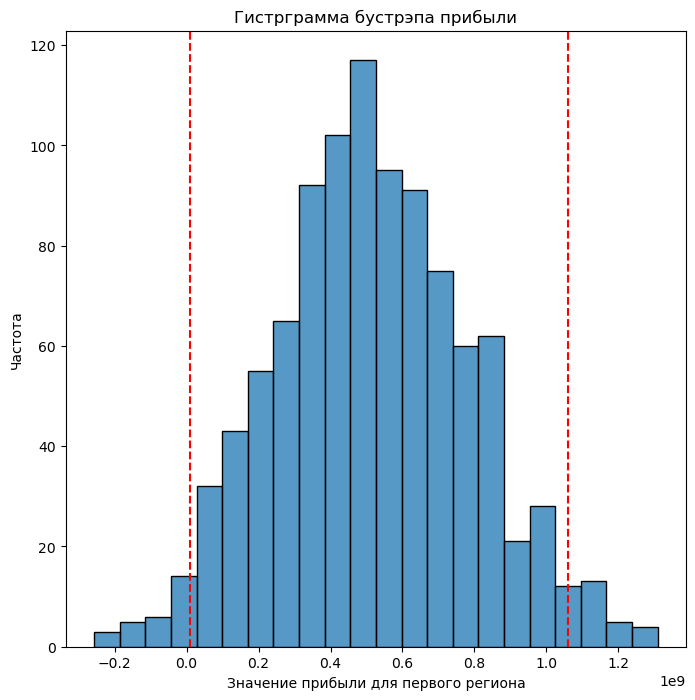

In [55]:
rev_list, lower, upper, risk = revenue_and_risk(geo_1_predictions, target_geo1_valid) # Добавил переменную upper
 
print(f'Средняя прибыль {round(rev_list.mean(), 2)}')
print('Вероятность отрицательный прибыли:', risk)
plt.figure(figsize=(8 , 8))
sns.histplot(rev_list)
plt.axvline(lower, color='red', linestyle='--')
plt.axvline(upper, color='red', linestyle='--') 
plt.ylabel('Частота')
plt.xlabel('Значение прибыли для первого региона')
plt.title('Гистрграмма бустрэпа прибыли')
plt.show();

Средняя прибыль 537008638.2
Вероятность отрицательный прибыли: 0.005


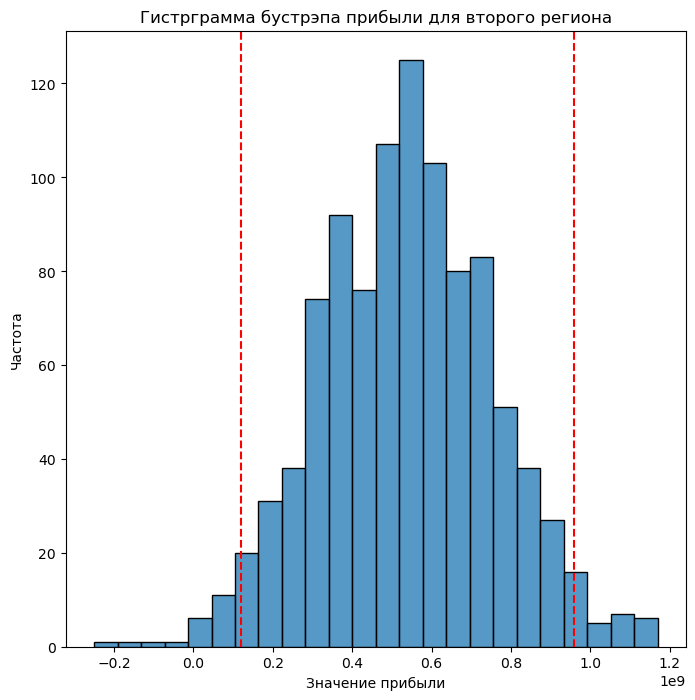

In [56]:
rev_list, lower, upper, risk = revenue_and_risk(geo_2_predictions, target_geo2_valid)

print(f'Средняя прибыль {round(rev_list.mean(), 2)}')
print('Вероятность отрицательный прибыли:', risk)
plt.figure(figsize=(8 , 8))
sns.histplot(rev_list)
plt.axvline(lower, color='red', linestyle='--')
plt.axvline(upper, color='red', linestyle='--')
plt.ylabel('Частота')
plt.xlabel('Значение прибыли')
plt.title('Гистрграмма бустрэпа прибыли для второго региона')
plt.show();

Средняя прибыль 619094906.83
Вероятность отрицательный прибыли: 0.01


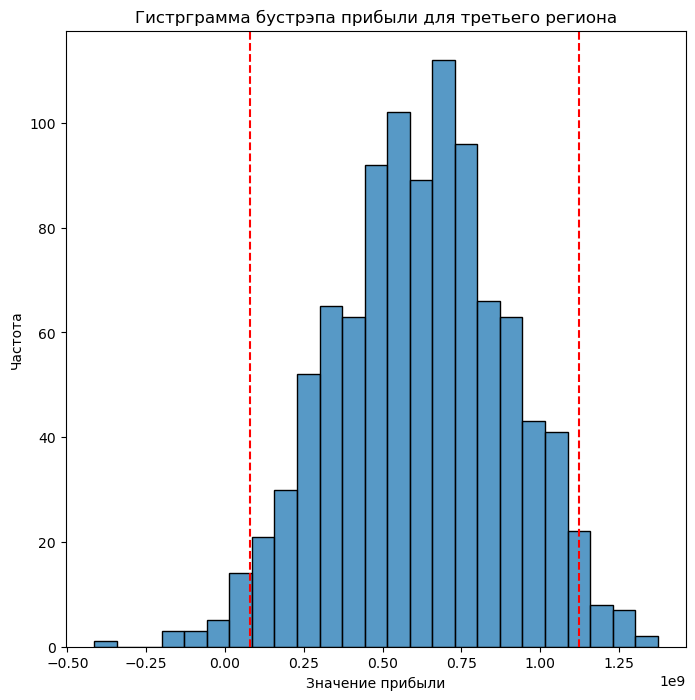

In [57]:
rev_list, lower, upper, risk = revenue_and_risk(geo_3_predictions, target_geo3_valid)


print(f'Средняя прибыль {round(rev_list.mean(), 2)}')
print('Вероятность отрицательный прибыли:', risk)
plt.figure(figsize=(8 , 8))
sns.histplot(rev_list)
plt.axvline(lower, color='red', linestyle='--')
plt.axvline(upper, color='red', linestyle='--')
plt.ylabel('Частота')
plt.xlabel('Значение прибыли')
plt.title('Гистрграмма бустрэпа прибыли для третьего региона')
plt.show();

## Вывод

<div style='border:solid blue 2px; padding: 10px'>
    
*Все 3 региона удовлетворяют условию "Вероятность убытков менее 2.5%"*

- Самым прибыльным является Третий регион с его показателем прибыли **619 094 906.83** и вероятностью убытков в **1%**
- Самым безопасным регионом является Второй с его показателм прибыли **537 008 638.2** и рисками в **0.5%**
- Первый регион проигрывает по всем показателям с его выручкой **514 837 829.09** и рисками **2.4%**
    
Имеется 2 стратегии инвестиций. С максимизацией прибыли и минимизацией рисков:
- При минимизации рисков в 2 раза (с 1% до 0.5%) прибыль падает в 0.867 раз.
    
**Данные со второго региона выглядят недоставерно, будто их создавали вручную.**
- Исходя из этого, стоит перепроверить источник данных
- Если перепроверить источник нельзя или данные были ложными, лучшим регионом по вкладам будет *Третий регион*